Época: 0/5000	Custo: 5.473E+00
Época: 50/5000	Custo: 2.366E+00
Época: 100/5000	Custo: 1.985E-02
Época: 150/5000	Custo: 2.875E-03
Época: 200/5000	Custo: 1.311E-03
Época: 250/5000	Custo: 7.615E-04
Época: 300/5000	Custo: 4.963E-04
Época: 350/5000	Custo: 3.490E-04
Época: 400/5000	Custo: 2.657E-04
Época: 450/5000	Custo: 2.163E-04
Época: 500/5000	Custo: 1.837E-04
Época: 550/5000	Custo: 1.592E-04
Época: 600/5000	Custo: 1.388E-04
Época: 650/5000	Custo: 1.212E-04
Época: 700/5000	Custo: 1.058E-04
Época: 750/5000	Custo: 9.225E-05
Época: 800/5000	Custo: 8.048E-05
Época: 850/5000	Custo: 7.031E-05
Época: 900/5000	Custo: 6.157E-05
Época: 950/5000	Custo: 5.407E-05
Época: 1000/5000	Custo: 4.764E-05
Época: 1050/5000	Custo: 4.210E-05
Época: 1100/5000	Custo: 3.731E-05
Época: 1150/5000	Custo: 3.313E-05
Época: 1200/5000	Custo: 2.946E-05
Época: 1250/5000	Custo: 2.620E-05
Época: 1300/5000	Custo: 2.331E-05
Época: 1350/5000	Custo: 2.071E-05
Época: 1400/5000	Custo: 1.839E-05
Época: 1450/5000	Custo: 1.630E-05
Épo

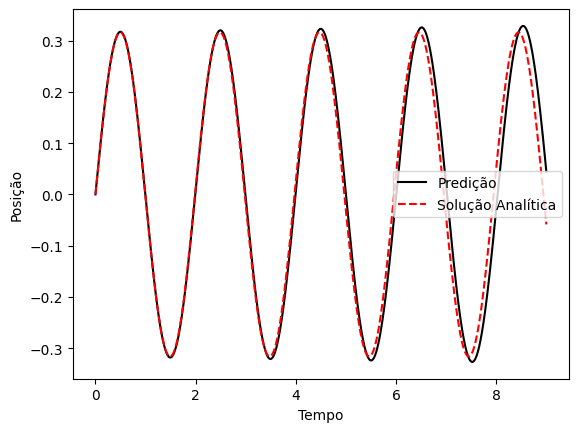

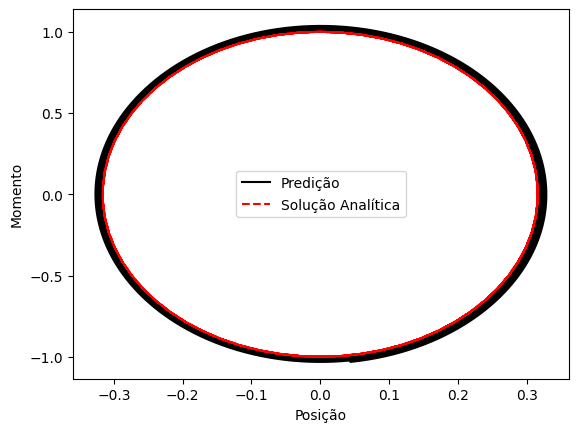

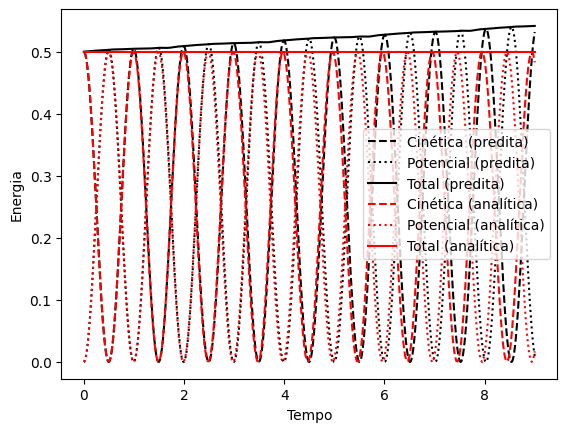

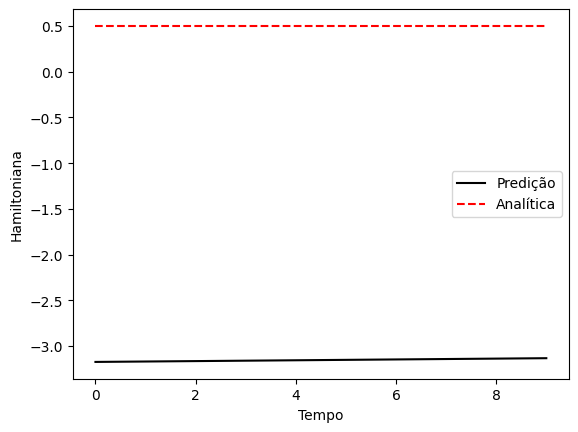

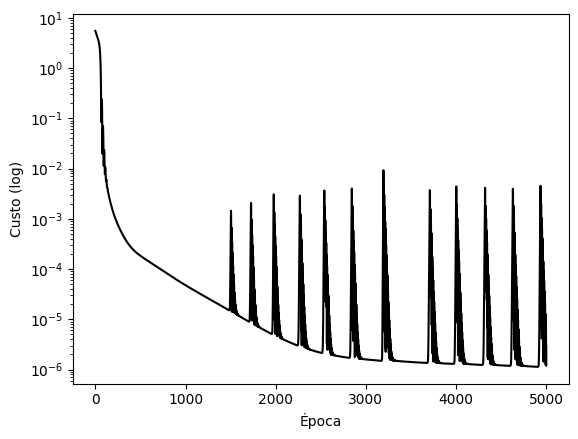

In [2]:
# Importação das bibliotecas necessárias
import torch  # Framework para redes neurais e diferenciação automática
import numpy as np  # Operações numéricas
from torch.autograd import grad  # Para cálculo de derivadas
import matplotlib.pyplot as plt  # Visualização dos resultados

# Configuração da semente para reprodutibilidade
torch.manual_seed(2)

# CONFIGURAÇÕES DO USUÁRIO ====================================================

# Parâmetros físicos do sistema massa-mola
dx0dt = 1  # Velocidade inicial
k = 10     # Constante da mola
m = 1      # Massa

# Parâmetros de amostragem para treinamento
tmaxTraining = 1.5  # Tempo máximo para dados de treino
numberOfTrainingSamples = 50  # Número de pontos de treino

# Parâmetros de amostragem para validação
tmaxValidation = 9  # Tempo máximo para dados de validação
numberOfValidationSamples = 300  # Número de pontos de validação

# Arquitetura da rede neural
neurons = 50  # Neurônios por camada oculta
layers = 2    # Número de camadas ocultas

# Hiperparâmetros de treinamento
lr = 1e-3    # Taxa de aprendizado
epochs = 5000  # Número de épocas de treinamento

# IMPLEMENTAÇÃO DA REDE NEURAL ================================================

class FNN(torch.nn.Module):
    """Feedforward Neural Network para aprendizado da Hamiltoniana."""

    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()
        self.layers = layers

        # Camadas da rede:
        # 1 camada de entrada, 'layers' camadas ocultas, 1 camada de saída
        self.linear1 = torch.nn.Linear(inputSize, neurons)  # Entrada para primeira oculta
        self.linear2 = torch.nn.ModuleList()  # Lista de camadas ocultas
        for _ in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)  # Última camada
        self.activation = torch.nn.Tanh()  # Função de ativação

    def forward(self, x):
        """Passagem forward da rede."""
        y = self.activation(self.linear1(x))  # Primeira camada
        for i in range(self.layers):  # Camadas ocultas
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)  # Camada de saída (sem ativação)
        return y

# FUNÇÃO PARA CÁLCULO DE DERIVADAS ============================================

def getDerivative(y, x, n):
    """Calcula a derivada de ordem n de y em relação a x usando autograd."""
    if n == 0:
        return y
    else:
        # Calcula derivada primeira
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n-1)  # Recursão para derivadas de ordem superior

# GERAÇÃO DOS DADOS ===========================================================

# Solução analítica do sistema massa-mola
omega = np.sqrt(k/m)  # Frequência natural
A = dx0dt/omega       # Amplitude
phi = 0               # Fase inicial

# Funções para posição, velocidade e aceleração analíticas
x = lambda t: A * np.sin(omega*t + phi)
dxdt = lambda t: omega * A * np.cos(omega*t + phi)
ddxdtt = lambda t: -omega**2 * A * np.sin(omega*t + phi)

# Dados de treinamento (intervalo de tempo menor)
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
trainingData = torch.vstack((
    torch.from_numpy(x(tTraining)),           # Posição (x)
    m * torch.from_numpy(dxdt(tTraining)),    # Momento (p = m*v)
    m * torch.from_numpy(ddxdtt(tTraining))   # Força (F = m*a)
)).to(torch.float32).T

# Dados de validação (intervalo de tempo maior)
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((
    torch.from_numpy(x(tValidation)),
    m * torch.from_numpy(dxdt(tValidation)),
    m * torch.from_numpy(ddxdtt(tValidation))
)).to(torch.float32).T

# Preparação da entrada do modelo (posição e momento)
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True  # Habilita cálculo de gradientes

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

# TREINAMENTO DO MODELO HAMILTONIANO ==========================================

# Criação e configuração do modelo
model = FNN(2, 1, neurons, layers)  # 2 entradas (x,p), 1 saída (H)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Otimizador
costHistory = np.zeros(epochs)  # Histórico do custo

# Loop de treinamento
for epoch in range(epochs):
    optimizer.zero_grad()  # Zera os gradientes

    # Predição da Hamiltoniana
    HPred = model(modelInputTraining)

    # Cálculo das derivadas (equações de Hamilton)
    dHPreddx = getDerivative(HPred, modelInputTraining, 1)

    # Função custo: erro nas equações de movimento
    cost = torch.mean(
        (dHPreddx[:, 0] + trainingData[:, 2])**2 +  # dx/dt = ∂H/∂p
        (dHPreddx[:, 1] - trainingData[:, 1]/m)**2   # dp/dt = -∂H/∂x
    )
    costHistory[epoch] = cost.detach()  # Armazena histórico

    # Backpropagation
    cost.backward()
    optimizer.step()

    # Log periódico
    if epoch % 50 == 0:
        print(f"Época: {epoch}/{epochs}\tCusto: {cost.detach():.3E}")

# PÓS-PROCESSAMENTO E VISUALIZAÇÃO ============================================

# Configuração da integração numérica
numberOfTimeSteps = 10000  # Número de passos para Euler
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps+1)
dt = tmaxValidation/numberOfTimeSteps  # Tamanho do passo

# Inicialização das variáveis para integração
xPrediction = torch.zeros((2, numberOfTimeSteps+1), requires_grad=False)
xPrediction[:, 0] = validationData[0, :2]  # Condições iniciais

HPredictions = np.zeros(numberOfTimeSteps)  # Para armazenar as predições de H
HLabel = 0.5*m*validationData[:, 1]**2 + 0.5*k*validationData[:, 0]**2  # H analítico

# Integração numérica usando as equações aprendidas
for i in range(numberOfTimeSteps):
    currentx = xPrediction[:, i].unsqueeze(0).detach()
    currentx.requires_grad = True

    # Predição da Hamiltoniana e suas derivadas
    HPred = model(currentx)
    HPredictions[i] = HPred[0].detach()
    dHPreddx = getDerivative(HPred, currentx, 1)

    # Método de Euler para integrar as equações
    xPrediction[:, i+1] = (xPrediction[:, i] + dt * torch.tensor([
        dHPreddx[0, 1],   # dx/dt = ∂H/∂p
        -dHPreddx[0, 0]   # dp/dt = -∂H/∂x
    ])).detach()

# Visualização dos resultados --------------------------------------------------

# 1. Resposta temporal
plt.figure()
plt.plot(tPrediction, xPrediction[0, :], 'k', label="Predição")
plt.plot(tValidation, validationData[:, 0], 'r--', label="Solução Analítica")
plt.xlabel("Tempo")
plt.ylabel("Posição")
plt.legend()
plt.show()

# 2. Espaço de fase (posição x momento)
plt.figure()
plt.plot(xPrediction[0, :], xPrediction[1, :], 'k', label="Predição")
plt.plot(validationData[:, 0], validationData[:, 1], 'r--', label="Solução Analítica")
plt.xlabel("Posição")
plt.ylabel("Momento")
plt.legend()
plt.show()

# 3. Evolução da energia (cinética, potencial e total)
plt.figure()
# Energias preditas
plt.plot(tPrediction, 0.5/m*xPrediction[1, :]**2, 'k--', label="Cinética (predita)")
plt.plot(tPrediction, 0.5*k*xPrediction[0, :]**2, 'k:', label="Potencial (predita)")
plt.plot(tPrediction, 0.5/m*xPrediction[1, :]**2 + 0.5*k*xPrediction[0, :]**2, 'k', label="Total (predita)")

# Energias analíticas
plt.plot(tValidation, 0.5/m*validationData[:, 1]**2, 'r--', label="Cinética (analítica)")
plt.plot(tValidation, 0.5*k*validationData[:, 0]**2, 'r:', label="Potencial (analítica)")
plt.plot(tValidation, 0.5/m*validationData[:, 1]**2 + 0.5*k*validationData[:, 0]**2, 'r', label="Total (analítica)")

plt.xlabel("Tempo")
plt.ylabel("Energia")
plt.legend()
plt.show()

# 4. Comparação da Hamiltoniana predita com a analítica
plt.figure()
plt.plot(tPrediction[:-1], HPredictions, 'k', label="Predição")
plt.plot(tValidation, HLabel, 'r--', label="Analítica")
plt.xlabel("Tempo")
plt.ylabel("Hamiltoniana")
plt.legend()
plt.show()

# 5. Histórico de treinamento (evolução da função custo)
plt.figure()
plt.plot(costHistory, 'k')
plt.yscale('log')
plt.xlabel("Época")
plt.ylabel("Custo (log)")
plt.show()